In [5]:
import numpy as np
import pandas as pd
import datetime as datetime
from prophet import Prophet
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# from prophet.serialize import StanBackendEnum
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# 使用相對路徑載入資料
housing_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house_price_monthly_bfill.csv', encoding='utf-8')

In [9]:
housing_data.head()

,date,house_index_xyi_all_tp,house_index_xyi_tp,house_index_xyi_new_tp,EA1101,EB0312,EB0911,EB18,EB21,EB22,...,航運業(TSE26)收盤,鋼鐵(TSE20)收盤,倫敦鋁現貨價,倫敦高級銅極現貨價,巴拿馬型貨櫃運費指數,杜拜輕原油現貨價,水泥50kg北區台泥,無鉛汽油95,竹節鋼筋_南,預拌混凝土3000磅台北
0,2011-01-31,95.40,94.45,96.84,34.0,28.8,1.0978,86.78,95.85,89.85,...,123.49,120.70,2450.300,9560.900,1738.2,91.6700,151.5,31.600,21260.0,1815.0
1,2011-02-28,97.69,97.34,98.23,34.0,28.8,1.3261,85.89,96.75,89.80,...,108.61,117.89,2513.250,9853.125,1696.0,99.7525,151.5,31.575,21250.0,1890.0
2,2011-03-31,97.76,97.86,97.61,31.0,28.8,1.3950,83.66,96.60,88.00,...,103.48,122.54,2548.875,9564.625,2071.5,109.1775,151.5,32.675,21525.0,1890.0
3,2011-04-30,97.31,98.38,95.69,29.0,28.8,1.2941,85.78,100.45,89.30,...,110.02,122.81,2682.700,9524.800,1601.0,115.6840,151.5,32.980,20500.0,1896.0
4,2011-05-31,96.85,97.02,96.60,27.0,28.8,1.6650,85.40,102.60,90.55,...,112.45,118.57,2587.625,8945.125,1755.0,105.4850,151.5,32.525,20175.0,1787.5


In [ ]:
eco_drop_list = ['EA1101', 'EB0312', 'EB0911',   'EB22', 'EC06', 'EC07',
          'LA07', 'MA1501', 'MB65', 'MC36G', 'MO30','MP101G',
          'NE0812', 'OC08G','倫敦鋁現貨價', '倫敦高級銅極現貨價',
          '巴拿馬型貨櫃運費指數', '杜拜輕原油現貨價', '水泥50kg北區台泥', '無鉛汽油95', '竹節鋼筋_南',]

In [11]:
housing_data.isnull().sum(axis=0)

date                      0
house_index_xyi_all_tp    0
house_index_xyi_tp        0
house_index_xyi_new_tp    0
EA1101                    0
EB0312                    0
EB0911                    0
EB18                      0
EB21                      0
EB22                      0
EC06                      0
EC07                      0
LA07                      0
MA1501                    0
MB65                      0
MC31                      0
MC31G                     0
MC36                      0
MC36G                     0
MO30                      0
MP101G                    0
NA0101                    0
NA1005                    0
NB0101                    0
NC0117                    0
NC0118                    0
NE0206                    0
NE0812                    0
OC08G                     0
PA0120                    0
PA1205                    0
PE0503                    0
TSE收盤                     0
水泥(TSE11)收盤               0
建材營造(TSE25)收盤             0
航運業(TSE26)收盤        

In [12]:
# 確保 date 列是 datetime 類型
housing_data['date'] = pd.to_datetime(housing_data['date'])

# 聚合數據到每個月
df_monthly = housing_data.resample('M', on='date').sum().reset_index()

# 顯示聚合後的數據
df_monthly.head()

,date,house_index_xyi_all_tp,house_index_xyi_tp,house_index_xyi_new_tp,EA1101,EB0312,EB0911,EB18,EB21,EB22,...,航運業(TSE26)收盤,鋼鐵(TSE20)收盤,倫敦鋁現貨價,倫敦高級銅極現貨價,巴拿馬型貨櫃運費指數,杜拜輕原油現貨價,水泥50kg北區台泥,無鉛汽油95,竹節鋼筋_南,預拌混凝土3000磅台北
0,2011-01-31,95.40,94.45,96.84,34.0,28.8,1.0978,86.78,95.85,89.85,...,123.49,120.70,2450.300,9560.900,1738.2,91.6700,151.5,31.600,21260.0,1815.0
1,2011-02-28,97.69,97.34,98.23,34.0,28.8,1.3261,85.89,96.75,89.80,...,108.61,117.89,2513.250,9853.125,1696.0,99.7525,151.5,31.575,21250.0,1890.0
2,2011-03-31,97.76,97.86,97.61,31.0,28.8,1.3950,83.66,96.60,88.00,...,103.48,122.54,2548.875,9564.625,2071.5,109.1775,151.5,32.675,21525.0,1890.0
3,2011-04-30,97.31,98.38,95.69,29.0,28.8,1.2941,85.78,100.45,89.30,...,110.02,122.81,2682.700,9524.800,1601.0,115.6840,151.5,32.980,20500.0,1896.0
4,2011-05-31,96.85,97.02,96.60,27.0,28.8,1.6650,85.40,102.60,90.55,...,112.45,118.57,2587.625,8945.125,1755.0,105.4850,151.5,32.525,20175.0,1787.5


### Prophet 單變量分析

In [18]:
# 準備數據，Prophet 要求日期列名為 'ds'，目標值列名為 'y'
df_monthly.rename(columns={'date': 'ds', 'house_index_xyi_all_tp': 'y'}, inplace=True)

# 選擇我們需要的列
df_monthly = df_monthly[['ds', 'y']]
print(df_monthly.head())


          ds      y
0 2011-01-31  95.40
1 2011-02-28  97.69
2 2011-03-31  97.76
3 2011-04-30  97.31
4 2011-05-31  96.85


In [43]:
# 創建 Prophet 模型實例並手動設置 Stan 後端
# model = Prophet(stan_backend=StanBackendEnum.PYSTAN.value)

# 創建 Prophet 模型
model = Prophet()

# 擬合模型
model.fit(df_monthly)

# 創建包含未來日期的資料框，預測未來 12 個月
future = model.make_future_dataframe(periods=6, freq='M')

# 預測未來
forecast = model.predict(future)

# 顯示預測結果
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa7v3l9a5/2cep3ibk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa7v3l9a5/kj1xwh31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68534', 'data', 'file=/tmp/tmpa7v3l9a5/2cep3ibk.json', 'init=/tmp/tmpa7v3l9a5/kj1xwh31.json', 'output', 'file=/tmp/tmpa7v3l9a5/prophet_modelkeaus3o_/prophet_model-20240703091727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:17:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:17:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
160 2024-05-31  169.338810  166.773947  171.889930
161 2024-06-30  170.814255  168.272791  173.538681
162 2024-07-31  171.672030  169.121299  174.249935
163 2024-08-31  171.232565  168.610685  173.825043
164 2024-09-30  171.850680  169.197070  174.771599


In [45]:
import prophet
print(prophet.__version__)

1.1.5


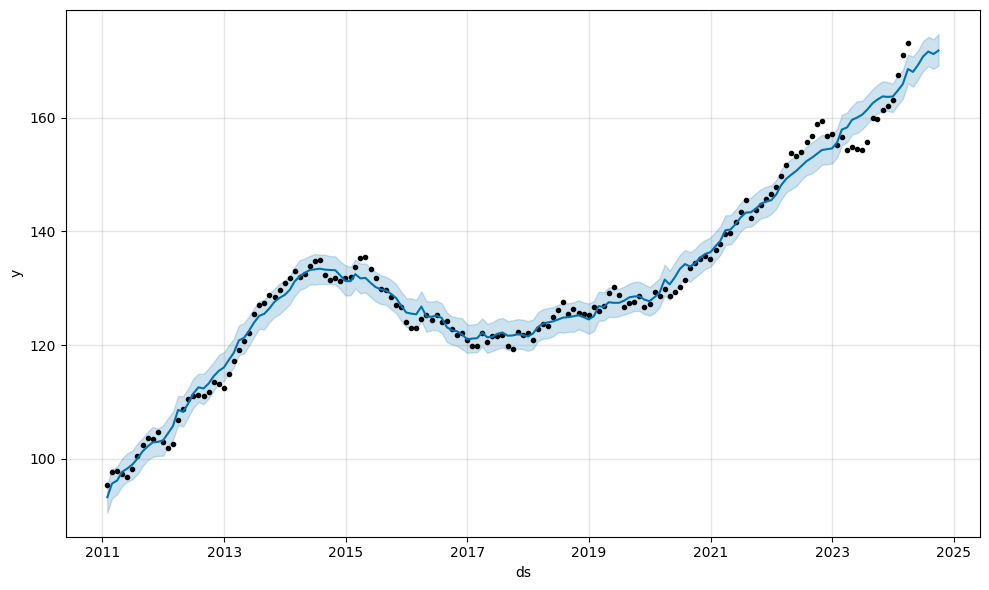

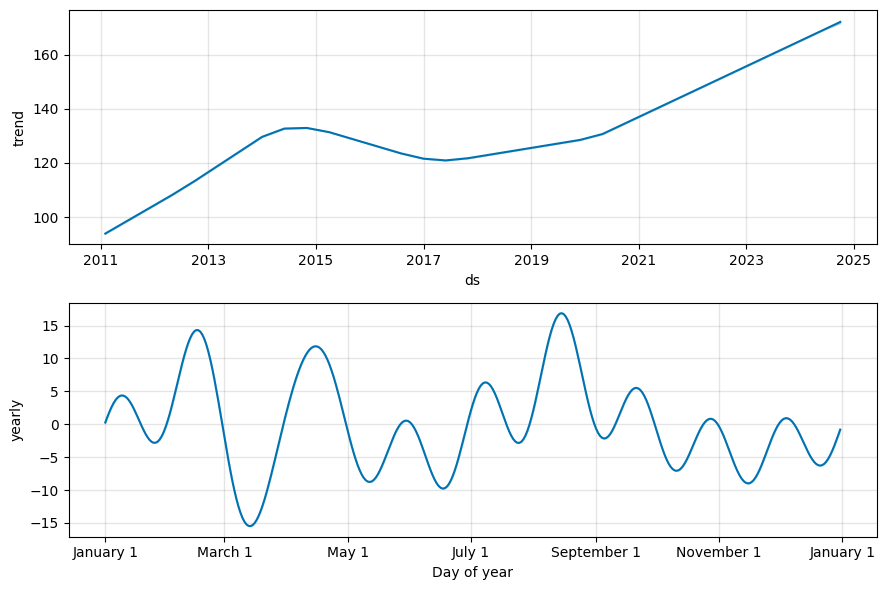

In [46]:
import matplotlib.pyplot as plt

# 繪製預測結果
fig1 = model.plot(forecast)
plt.show()

# 繪製預測成分
fig2 = model.plot_components(forecast)
plt.show()


### Prophet 多變量分析

In [56]:
import pandas as pd

# 使用相對路徑載入資料
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house_price_monthly_bfill.csv', encoding='utf-8')

# 顯示前兩行數據以確認讀取成功
df.head(2)

,date,house_index_xyi_all_tp,house_index_xyi_tp,house_index_xyi_new_tp,EA1101,EB0312,EB0911,EB18,EB21,EB22,...,航運業(TSE26)收盤,鋼鐵(TSE20)收盤,倫敦鋁現貨價,倫敦高級銅極現貨價,巴拿馬型貨櫃運費指數,杜拜輕原油現貨價,水泥50kg北區台泥,無鉛汽油95,竹節鋼筋_南,預拌混凝土3000磅台北
0,2011-01-31,95.40,94.45,96.84,34.0,28.8,1.0978,86.78,95.85,89.85,...,123.49,120.70,2450.30,9560.900,1738.2,91.6700,151.5,31.600,21260.0,1815.0
1,2011-02-28,97.69,97.34,98.23,34.0,28.8,1.3261,85.89,96.75,89.80,...,108.61,117.89,2513.25,9853.125,1696.0,99.7525,151.5,31.575,21250.0,1890.0


In [30]:
df.columns

Index(['date', 'house_index_xyi_all_tp', 'house_index_xyi_tp',
       'house_index_xyi_new_tp', 'EA1101', 'EB0312', 'EB0911', 'EB18', 'EB21',
       'EB22', 'EC06', 'EC07', 'LA07', 'MA1501', 'MB65', 'MC31', 'MC31G',
       'MC36', 'MC36G', 'MO30', 'MP101G', 'NA0101', 'NA1005', 'NB0101',
       'NC0117', 'NC0118', 'NE0206', 'NE0812', 'OC08G', 'PA0120', 'PA1205',
       'PE0503', 'TSE收盤', '水泥(TSE11)收盤', '建材營造(TSE25)收盤', '航運業(TSE26)收盤',
       '鋼鐵(TSE20)收盤', '倫敦鋁現貨價', '倫敦高級銅極現貨價', '巴拿馬型貨櫃運費指數', '杜拜輕原油現貨價',
       '水泥50kg北區台泥', '無鉛汽油95', '竹節鋼筋_南', '預拌混凝土3000磅台北'],
      dtype='object')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    159 non-null    object 
 1   house_index_xyi_all_tp  159 non-null    float64
 2   house_index_xyi_tp      159 non-null    float64
 3   house_index_xyi_new_tp  159 non-null    float64
 4   EA1101                  159 non-null    float64
 5   EB0312                  159 non-null    float64
 6   EB0911                  159 non-null    float64
 7   EB18                    159 non-null    float64
 8   EB21                    159 non-null    float64
 9   EB22                    159 non-null    float64
 10  EC06                    159 non-null    float64
 11  EC07                    159 non-null    float64
 12  LA07                    159 non-null    float64
 13  MA1501                  159 non-null    float64
 14  MB65                    159 non-null    fl

In [57]:
import pandas as pd
from prophet import Prophet

# 假設你的數據框 df 已經加載

# 確保 date 列是 datetime 類型
df['date'] = pd.to_datetime(df['date'])

# 檢查缺失值
eco_drop_list = ['EA1101', 'EB0312', 'EB0911', 'EB22', 'EC06', 'EC07',
                 'LA07', 'MA1501', 'MB65', 'MC36G', 'MO30', 'MP101G',
                 'NE0812', 'OC08G', '倫敦鋁現貨價', '倫敦高級銅極現貨價',
                 '巴拿馬型貨櫃運費指數', '杜拜輕原油現貨價', '水泥50kg北區台泥', '無鉛汽油95', '竹節鋼筋_南']

# 填充缺失值
for var in eco_drop_list:
    if var not in df.columns:
        raise ValueError(f"回歸變量 '{var}' 不在數據框中。請確保所有需要的回歸變量都在數據框中。")
    df[var].fillna(df[var].mean(), inplace=True)

# 確保所有日期都有數據，補全日期範圍
df.set_index('date', inplace=True)
df = df.asfreq('D').reset_index()

# 準備數據，Prophet 要求日期列名為 'ds'，目標值列名為 'y'
df.rename(columns={'date': 'ds', 'house_index_xyi_all_tp': 'y'}, inplace=True)

# 聚合數據到每個月，使用 'mean' 來聚合回歸變量
df_monthly = df.resample('M', on='ds').mean().reset_index()

# 檢查聚合後的數據框是否缺少變量，如果缺少，使用原始數據框中的均值來填充這些變量
for var in eco_drop_list:
    if var not in df_monthly.columns:
        print(f"警告: 聚合後數據框中缺少回歸變量 '{var}'，將用原始數據框中的均值填充。")
        df_monthly[var] = df[var].mean()

# 填充聚合後的缺失值
for var in eco_drop_list:
    if df_monthly[var].isna().sum() > 0:
        print(f"填充聚合後數據框中 '{var}' 的缺失值。")
        df_monthly[var].fillna(method='bfill', inplace=True)

# 確保數據框格式符合 Prophet 要求
df_monthly.rename(columns={'ds': 'ds', 'y': 'y'}, inplace=True)

# 打印最終數據框，檢查格式是否正確
print(df_monthly.head())

# 構建 Prophet 模型
m = Prophet(daily_seasonality=True)

# 添加回歸變量
for var in eco_drop_list:
    if var != 'y':  # 已經作為 'y' 列
        m.add_regressor(var)

# 訓練模型
m.fit(df_monthly)

# 顯示聚合後的數據
print(df_monthly.head())


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa7v3l9a5/95x4xuro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa7v3l9a5/bnmoa2hj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7815', 'data', 'file=/tmp/tmpa7v3l9a5/95x4xuro.json', 'init=/tmp/tmpa7v3l9a5/bnmoa2hj.json', 'output', 'file=/tmp/tmpa7v3l9a5/prophet_modely97zr8uf/prophet_model-20240703092116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:21:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


          ds      y  house_index_xyi_tp  house_index_xyi_new_tp  EA1101  \
0 2011-01-31  95.40               94.45                   96.84    34.0   
1 2011-02-28  97.69               97.34                   98.23    34.0   
2 2011-03-31  97.76               97.86                   97.61    31.0   
3 2011-04-30  97.31               98.38                   95.69    29.0   
4 2011-05-31  96.85               97.02                   96.60    27.0   

   EB0312  EB0911   EB18    EB21   EB22  ...  航運業(TSE26)收盤  鋼鐵(TSE20)收盤  \
0    28.8  1.0978  86.78   95.85  89.85  ...        123.49       120.70   
1    28.8  1.3261  85.89   96.75  89.80  ...        108.61       117.89   
2    28.8  1.3950  83.66   96.60  88.00  ...        103.48       122.54   
3    28.8  1.2941  85.78  100.45  89.30  ...        110.02       122.81   
4    28.8  1.6650  85.40  102.60  90.55  ...        112.45       118.57   

     倫敦鋁現貨價  倫敦高級銅極現貨價  巴拿馬型貨櫃運費指數  杜拜輕原油現貨價  水泥50kg北區台泥  無鉛汽油95   竹節鋼筋_南  \
0  2450.300   9560.90

09:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds      y  house_index_xyi_tp  house_index_xyi_new_tp  EA1101  \
0 2011-01-31  95.40               94.45                   96.84    34.0   
1 2011-02-28  97.69               97.34                   98.23    34.0   
2 2011-03-31  97.76               97.86                   97.61    31.0   
3 2011-04-30  97.31               98.38                   95.69    29.0   
4 2011-05-31  96.85               97.02                   96.60    27.0   

   EB0312  EB0911   EB18    EB21   EB22  ...  航運業(TSE26)收盤  鋼鐵(TSE20)收盤  \
0    28.8  1.0978  86.78   95.85  89.85  ...        123.49       120.70   
1    28.8  1.3261  85.89   96.75  89.80  ...        108.61       117.89   
2    28.8  1.3950  83.66   96.60  88.00  ...        103.48       122.54   
3    28.8  1.2941  85.78  100.45  89.30  ...        110.02       122.81   
4    28.8  1.6650  85.40  102.60  90.55  ...        112.45       118.57   

     倫敦鋁現貨價  倫敦高級銅極現貨價  巴拿馬型貨櫃運費指數  杜拜輕原油現貨價  水泥50kg北區台泥  無鉛汽油95   竹節鋼筋_南  \
0  2450.300   9560.90

In [62]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# 使用相對路徑載入資料
df = pd.read_csv('/content/sample_data/df_monthly_housingIndex.csv', encoding='utf-8')

# 確保 date 列是 datetime 類型
df['date'] = pd.to_datetime(df['date'])

# 檢查並填充缺失值
exogenous_vars = ['信義房屋-台北地區住宅指數', 'EA1101', 'EB0312', 'EB0911', 'EB18', 'EB21',
       'EB22', 'EC06', 'EC07', 'LA07', 'MA1501', 'MB65', 'MC31', 'MC31G',
       'MC36', 'MC36G', 'MO30', 'MP101G', 'NA0101', 'NA1005', 'NB0101',
       'NC0117', 'NC0118', 'NE0206', 'NE0812', 'OC08G', 'PA0120', 'PA1205',
       'PE0503', 'TSE收盤', '水泥(TSE11)收盤', '建材營造(TSE25)收盤', '航運業(TSE26)收盤',
       '鋼鐵(TSE20)收盤', '倫敦鋁現貨價', '倫敦高級銅極現貨價', '巴拿馬型貨櫃運費指數', '杜拜輕原油現貨價',
       '水泥50kg北區台泥', '無鉛汽油95', '竹節鋼筋_南', '預拌混凝土3000磅台北']

# 確保所有回歸變量都存在於數據框中，並填充缺失值
for var in exogenous_vars:
    if var not in df.columns:
        raise ValueError(f"回歸變量 '{var}' 不在數據框中。請確保所有需要的回歸變量都在數據框中。")
    df[var].fillna(df[var].mean(), inplace=True)

# 確保所有日期都有數據，補全日期範圍
df = df.set_index('date').asfreq('D').reset_index()

# 聚合數據到每個月，使用 'mean' 來聚合回歸變量
df_monthly = df.resample('M', on='date').mean().reset_index()

# 填充聚合後的缺失值
for var in exogenous_vars:
    if var not in df_monthly.columns:
        df_monthly[var] = df[var].mean()
    if df_monthly[var].isna().sum() > 0:
        df_monthly[var].fillna(df_monthly[var].mean(), inplace=True)

# 確保數據框格式符合 Prophet 要求
df_monthly.rename(columns={'date': 'ds', '信義房屋-台北地區住宅指數': 'y'}, inplace=True)

# 打印最終數據框，檢查格式是否正確
print(df_monthly.head())

# 將資料分成訓練集和測試集
train_data = df_monthly.iloc[:-42]
test_data = df_monthly.iloc[-42:]

# 構建 Prophet 模型
m = Prophet(daily_seasonality=True)

# 添加回歸變量
for var in exogenous_vars:
    if var != '信義房屋-台北地區住宅指數':  # 已經作為 'y' 列
        m.add_regressor(var)

# 訓練模型
m.fit(train_data)

# 創建測試期間的日期範圍，這裡我們需要確保日期範圍與測試集匹配
future_test = test_data[['ds']].copy()
for var in exogenous_vars:
    if var != '信義房屋-台北地區住宅指數':
        future_test[var] = test_data[var].values

# 確保未來數據框中包含所有需要的回歸變量
print("未來數據框列名：", future_test.columns)

# 進行預測
forecast_test = m.predict(future_test)

# 計算均方根誤差
y_true = test_data['y'].values
y_pred = forecast_test['yhat'].values
rmse = mean_squared_error(y_true, y_pred, squared=False)
rmse = mean_squared_error(, y_pred, squared=False)
print(f'RMSE: {rmse}')

SyntaxError: invalid syntax (<ipython-input-62-57bc31f6e11f>, line 17)

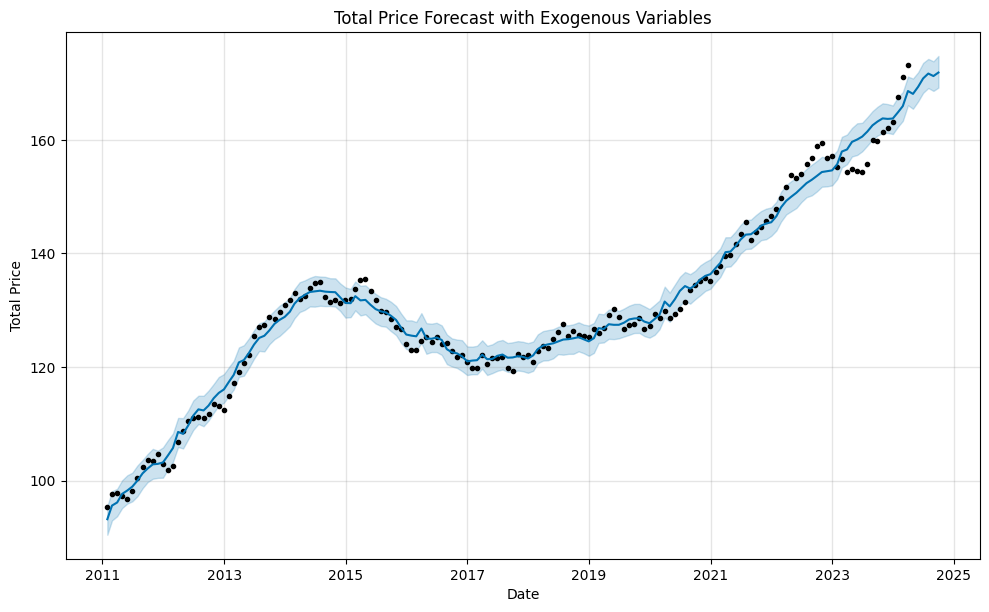

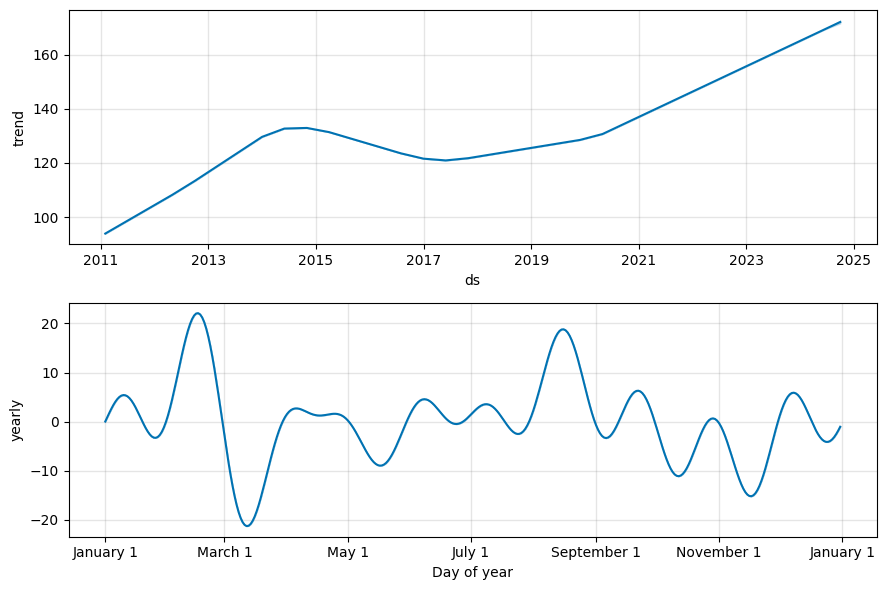

In [58]:
import matplotlib.pyplot as plt

# 繪製預測結果
fig1 = m.plot(forecast)
plt.title("Total Price Forecast with Exogenous Variables")
plt.xlabel("Date")
plt.ylabel("Total Price")
plt.show()

# 繪製預測組件
fig2 = m.plot_components(forecast)
plt.show()

In [50]:
# 構建 Prophet 模型
m = Prophet(daily_seasonality=True)

In [51]:
len(df.columns)

45

In [52]:
# 將資料分成訓練集和測試集
train_data = df_monthly.iloc[:-42]
test_data = df_monthly.iloc[-42:]

In [53]:
train_data

,ds,y,house_index_xyi_tp,house_index_xyi_new_tp,EA1101,EB0312,EB0911,EB18,EB21,EB22,...,航運業(TSE26)收盤,鋼鐵(TSE20)收盤,倫敦鋁現貨價,倫敦高級銅極現貨價,巴拿馬型貨櫃運費指數,杜拜輕原油現貨價,水泥50kg北區台泥,無鉛汽油95,竹節鋼筋_南,預拌混凝土3000磅台北
0,2011-01-31,95.40,94.45,96.84,34.0,28.8,1.0978,86.78,95.85,89.85,...,123.49,120.70,2450.300,9560.900,1738.20,91.6700,151.5,31.600000,21260.0,1815.0
1,2011-02-28,97.69,97.34,98.23,34.0,28.8,1.3261,85.89,96.75,89.80,...,108.61,117.89,2513.250,9853.125,1696.00,99.7525,151.5,31.575000,21250.0,1890.0
2,2011-03-31,97.76,97.86,97.61,31.0,28.8,1.3950,83.66,96.60,88.00,...,103.48,122.54,2548.875,9564.625,2071.50,109.1775,151.5,32.675000,21525.0,1890.0
3,2011-04-30,97.31,98.38,95.69,29.0,28.8,1.2941,85.78,100.45,89.30,...,110.02,122.81,2682.700,9524.800,1601.00,115.6840,151.5,32.980000,20500.0,1896.0
4,2011-05-31,96.85,97.02,96.60,27.0,28.8,1.6650,85.40,102.60,90.55,...,112.45,118.57,2587.625,8945.125,1755.00,105.4850,151.5,32.525000,20175.0,1787.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2020-05-31,129.27,123.76,137.61,19.0,30.8,-1.2095,64.87,74.51,79.05,...,59.65,87.82,1462.100,5205.700,672.60,32.7900,156.5,19.160000,14800.0,2025.0
113,2020-06-30,130.17,124.51,138.74,19.0,44.1,-0.7395,68.77,75.55,82.90,...,60.21,90.34,1568.375,5798.625,1025.00,40.3250,156.5,22.400000,15175.0,2025.0
114,2020-07-31,131.47,126.38,139.19,21.0,49.3,-0.5071,69.43,73.30,82.65,...,57.82,87.42,1623.375,6303.000,1401.25,42.4450,156.5,23.666667,14850.0,2025.0
115,2020-08-31,133.54,128.80,140.73,26.0,53.5,-0.3348,71.33,71.30,84.85,...,66.48,90.77,1728.800,6503.700,1576.80,43.5360,156.5,24.000000,15220.0,2025.0


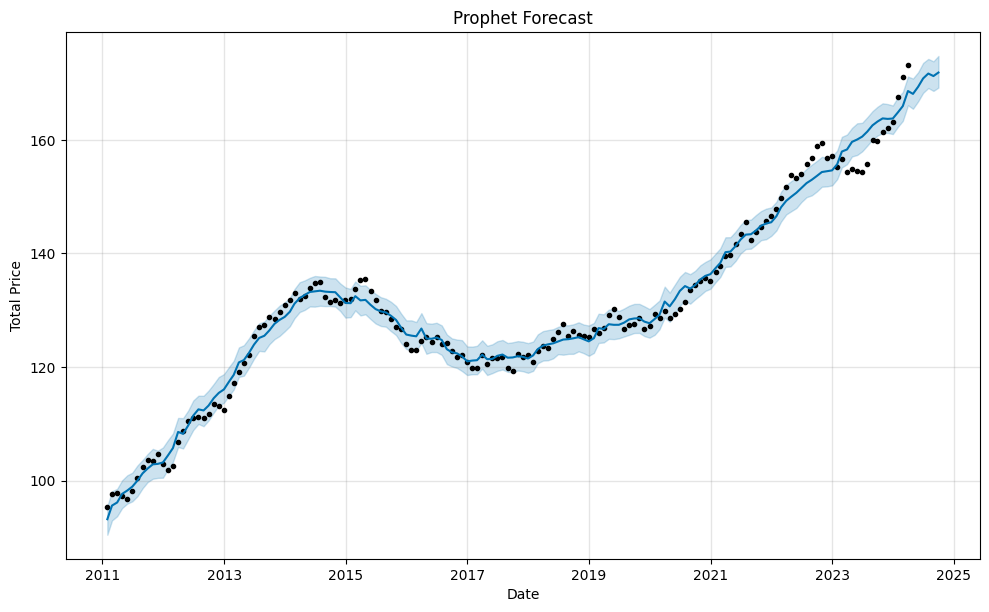

In [59]:
# 繪製預測圖形
fig = m.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Total Price')
plt.show()

In [61]:
# 構建未來數據框，預測 6 個月，確保包含所有回歸變量
future = m.make_future_dataframe(periods=6, freq='M')

# 進行預測
forecast = m.predict(future)

# 顯示預測結果
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

ValueError: Regressor 'EA1101' missing from dataframe